## Load Libraries

In [35]:
#import winsound
import os
import matplotlib.pyplot as py
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay\
                          , auc, accuracy_score, classification_report

import tensorflow as tf
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.efficientnet import EfficientNetB7
from keras.applications.inception_resnet_v2 import InceptionResNetV2

import keras_tuner
from kerastuner.tuners import RandomSearch

## Avoid **OOM**

In [36]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    pass

**Global Variables**

In [37]:
image_size = (299, 299) # must tuple of 3D for keras
seed = 45
path = "DataSet-Handle/"

## Load Data

In [38]:
# Load Images and make augmentation 
datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, 
                             zoom_range=0.2, horizontal_flip=True) 

# loading...
train_it = datagen.flow_from_directory(path + "Train", class_mode='categorical', seed=seed, 
              color_mode='grayscale', target_size = image_size)

valid_it = datagen.flow_from_directory(path + "Validation", class_mode='categorical', seed=seed, 
              color_mode='grayscale', target_size = image_size)

test_it = datagen.flow_from_directory(path + "Test", class_mode='categorical', seed=seed, 
              color_mode='grayscale', target_size = image_size)

Found 28651 images belonging to 4 classes.
Found 9701 images belonging to 4 classes.
Found 7756 images belonging to 4 classes.


### Build Model Arch

In [6]:
def build_model(cnn):
    
    # Freeze the CNN to limit training time 
    # where using it to Feature Extraction
    for layer in cnn.layers:layer.trainable= False
    
    # Build ANN contains 1 Hidden-layers & 2-Dropout  
      
        ## use 'Dropout' to avoid overfitting as regularization layer
    x = layers.Dropout(0.2)(cnn.output)    
    x = layers.Dense(units= 512, activation= 'relu')(x) 
    x = layers.Dropout(0.2)(x)  
       ## add output layer "4-classes"
    outputs = layers.Dense(units=4, activation='softmax')(x)
    
    # Model that will be trained
    model = tf.keras.Model(inputs=cnn.input, outputs=outputs)  
    model.compile(
        optimizer= tf.keras.optimizers.SGD(0.01),
        loss= tf.keras.losses.CategoricalCrossentropy(),
        metrics= [tf.keras.metrics.CategoricalAccuracy(), 
                  tf.keras.metrics.AUC()])
    return model


## Try ***Res & Efficient & Inception***

### ResNet50

In [7]:
# Train model 
res = build_model(ResNet50(include_top= False,
                              weights= None, input_shape= image_size + (1,), 
                              pooling= 'max', classes= 500))

hist_res = res.fit_generator(train_it,steps_per_epoch= 100, epochs= 10, validation_data= valid_it)
#winsound.Beep(1000,2000) ### as a reminder after the process is finished  ^_^

2022-10-08 17:16:43.851309: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-08 17:16:43.851821: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 17:16:43.852667: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 17:16:43.853349: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Epoch 1/10


2022-10-08 17:16:49.458813: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


100/100 [==============================] - 103s 994ms/step - loss: 1.3883 - categorical_accuracy: 0.2595 - auc: 0.4945 - val_loss: 1.3855 - val_categorical_accuracy: 0.2339 - val_auc: 0.5167
Epoch 2/10
100/100 [==============================] - 98s 983ms/step - loss: 1.3852 - categorical_accuracy: 0.2512 - auc: 0.5155 - val_loss: 1.3844 - val_categorical_accuracy: 0.2497 - val_auc: 0.5375
Epoch 3/10
100/100 [==============================] - 98s 986ms/step - loss: 1.3858 - categorical_accuracy: 0.2338 - auc: 0.5070 - val_loss: 1.3820 - val_categorical_accuracy: 0.2379 - val_auc: 0.5472
Epoch 4/10
100/100 [==============================] - 98s 986ms/step - loss: 1.3834 - categorical_accuracy: 0.2478 - auc: 0.5271 - val_loss: 1.3808 - val_categorical_accuracy: 0.2518 - val_auc: 0.5540
Epoch 5/10
100/100 [==============================] - 99s 998ms/step - loss: 1.3817 - categorical_accuracy: 0.2647 - auc: 0.5402 - val_loss: 1.3790 - val_categorical_accuracy: 0.2505 - val_auc: 0.5561
Epoch

In [8]:
res.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 1) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 305, 305, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

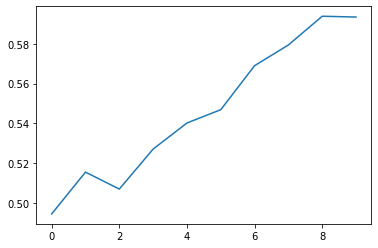

In [9]:
# plot auc curve
py.plot(hist_res.history['auc'])

In [10]:
res.evaluate_generator(valid_it)
#winsound.Beep(1000,2000) ###

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[1.371328353881836, 0.3433666527271271, 0.6466177701950073]

In [11]:
res.evaluate_generator(test_it)
#winsound.Beep(1000,2000) ###

[1.3714245557785034, 0.3423156142234802, 0.6464202404022217]

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Classification Report :                precision    recall  f1-score   support

           0       0.00      0.00      0.00      1949
           1       0.25      0.90      0.39      1942
           2       0.00      0.00      0.00      1942
           3       0.24      0.09      0.13      1923

    accuracy                           0.25      7756
   macro avg       0.12      0.25      0.13      7756
weighted avg       0.12      0.25      0.13      7756

Accuracy :  0.24793708096957195


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


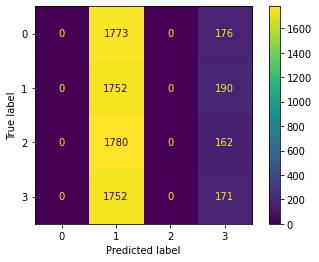

In [12]:
res_pre = res.predict_generator(test_it)
#winsound.Beep(1000,2000) ###

res_pre = [np.argmax(i) for i in res_pre]
print("Classification Report : ", classification_report(test_it.classes, res_pre))
print("Accuracy : ", accuracy_score(test_it.classes, res_pre))
ConfusionMatrixDisplay(confusion_matrix(test_it.classes, res_pre)).plot()

### EfficientNetB7

In [13]:
# Train model 
eff = build_model(EfficientNetB7(include_top= False,
                              weights= None, input_shape= image_size + (1,), 
                              pooling= 'max', classes= 500))

hist_eff = eff.fit_generator(train_it,steps_per_epoch= 150, epochs= 10, validation_data= valid_it)
#winsound.Beep(1000,2000) ### as a reminder after the process is finished  ^_^

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
150/150 [==============================] - 203s 1s/step - loss: 1.3864 - categorical_accuracy: 0.2492 - auc_1: 0.4968 - val_loss: 1.3863 - val_categorical_accuracy: 0.2518 - val_auc_1: 0.5012
Epoch 2/10
150/150 [==============================] - 179s 1s/step - loss: 1.3864 - categorical_accuracy: 0.2467 - auc_1: 0.4972 - val_loss: 1.3863 - val_categorical_accuracy: 0.2497 - val_auc_1: 0.4998
Epoch 3/10
150/150 [==============================] - 179s 1s/step - loss: 1.3864 - categorical_accuracy: 0.2502 - auc_1: 0.4990 - val_loss: 1.3863 - val_categorical_accuracy: 0.2497 - val_auc_1: 0.4998
Epoch 4/10
150/150 [==============================] - 179s 1s/step - loss: 1.3859 - categorical_accuracy: 0.2625 - auc_1: 0.5102 - val_loss: 1.3866 - val_categorical_accuracy: 0.2467 - val_auc_1: 0.4976
Epoch 5/10
150/150 [==============================] - 179s 1s/step - loss: 1.3866 - categorical_accuracy: 0.2467 - auc_1: 0.4959 - val_loss: 1.3864 - val_categorical_accuracy: 0.2497 - val

In [14]:
eff.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 1) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 299, 299, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 299, 299, 1)  3           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 1)  0           normalization[0][0]              
____________________________________________________________________________________________

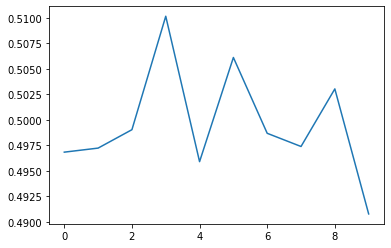

In [22]:
py.plot(hist_eff.history['auc_1'])

In [19]:
hist_eff.history['categorical_accuracy']

[0.24921531975269318,
 0.24666666984558105,
 0.2502083480358124,
 0.26249998807907104,
 0.24666666984558105,
 0.25958332419395447,
 0.25041666626930237,
 0.2460765838623047,
 0.25958332419395447,
 0.234375]

In [23]:
eff.evaluate(valid_it)
#winsound.Beep(1000,2000) ###

304/304 [==============================] - 120s 396ms/step - loss: 1.3863 - categorical_accuracy: 0.2518 - auc_1: 0.5000


[1.3862948417663574, 0.25182971358299255, 0.5]

In [25]:
eff.evaluate(test_it)
#winsound.Beep(1000,2000) ###

243/243 [==============================] - 97s 396ms/step - loss: 1.3863 - categorical_accuracy: 0.2504 - auc_1: 0.5000


[1.3862944841384888, 0.2503868043422699, 0.5]

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Classification Report :                precision    recall  f1-score   support

           0       0.00      0.00      0.00      1949
           1       0.25      1.00      0.40      1942
           2       0.00      0.00      0.00      1942
           3       0.00      0.00      0.00      1923

    accuracy                           0.25      7756
   macro avg       0.06      0.25      0.10      7756
weighted avg       0.06      0.25      0.10      7756

Accuracy :  0.25038679731820523


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


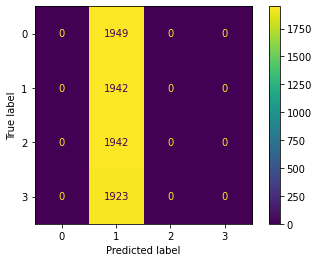

In [26]:
eff_pre = eff.predict_generator(test_it)
#winsound.Beep(1000,2000) ###

eff_pre = [np.argmax(i) for i in eff_pre]
print("Classification Report : ", classification_report(test_it.classes, eff_pre))
print("Accuracy : ", accuracy_score(test_it.classes, eff_pre))
ConfusionMatrixDisplay(confusion_matrix(test_it.classes, eff_pre)).plot()

### InceptionResNetV2

In [27]:
# Train model 
inc = build_model(InceptionResNetV2(include_top= False,
                              weights= None, input_shape= image_size + (1,), 
                              pooling= 'max', classes= 500))

hist_inc = res.fit_generator(train_it,steps_per_epoch= 100, epochs= 10, validation_data= valid_it)
#winsound.Beep(1000,2000) ### as a reminder after the process is finished  ^_^

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
100/100 [==============================] - 97s 980ms/step - loss: 1.3716 - categorical_accuracy: 0.3416 - auc: 0.6204 - val_loss: 1.3694 - val_categorical_accuracy: 0.3561 - val_auc: 0.6475
Epoch 2/10
100/100 [==============================] - 99s 992ms/step - loss: 1.3706 - categorical_accuracy: 0.3212 - auc: 0.6139 - val_loss: 1.3677 - val_categorical_accuracy: 0.3315 - val_auc: 0.6460
Epoch 3/10
100/100 [==============================] - 98s 985ms/step - loss: 1.3689 - categorical_accuracy: 0.3194 - auc: 0.6155 - val_loss: 1.3657 - val_categorical_accuracy: 0.3758 - val_auc: 0.6823
Epoch 4/10
100/100 [==============================] - 98s 986ms/step - loss: 1.3679 - categorical_accuracy: 0.3456 - auc: 0.6263 - val_loss: 1.3642 - val_categorical_accuracy: 0.3887 - val_auc: 0.6963
Epoch 5/10
100/100 [==============================] - 97s 980ms/step - loss: 1.3656 - categorical_accuracy: 0.3516 - auc: 0.6364 - val_loss: 1.3621 - val_categorical_accuracy: 0.3686 - val_auc: 0.

In [28]:
inc.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 288         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

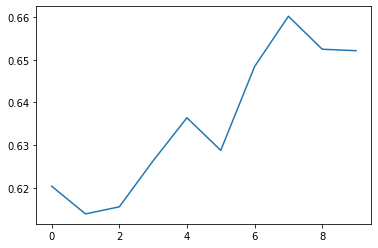

In [31]:
py.plot(hist_inc.history['auc'])

In [30]:
hist_inc.history['categorical_accuracy']

[0.34156250953674316,
 0.32124999165534973,
 0.31937500834465027,
 0.34562501311302185,
 0.3515625,
 0.34312498569488525,
 0.36531248688697815,
 0.3696874976158142,
 0.36656248569488525,
 0.3631249964237213]

In [32]:
inc.evaluate(valid_it)
#winsound.Beep(1000,2000) ###

304/304 [==============================] - 89s 278ms/step - loss: 1.3863 - categorical_accuracy: 0.2467 - auc_2: 0.4985


[1.3862723112106323, 0.24667559564113617, 0.49851542711257935]

In [34]:
inc.evaluate(test_it)
#winsound.Beep(1000,2000) ###

243/243 [==============================] - 68s 277ms/step - loss: 1.3862 - categorical_accuracy: 0.2479 - auc_2: 0.4994


[1.3862299919128418, 0.24793708324432373, 0.49938371777534485]

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Classification Report :                precision    recall  f1-score   support

           0       0.00      0.00      0.00      1949
           1       0.25      0.81      0.39      1942
           2       0.32      0.04      0.07      1942
           3       0.26      0.18      0.21      1923

    accuracy                           0.26      7756
   macro avg       0.21      0.26      0.17      7756
weighted avg       0.21      0.26      0.17      7756

Accuracy :  0.2574780814853017


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


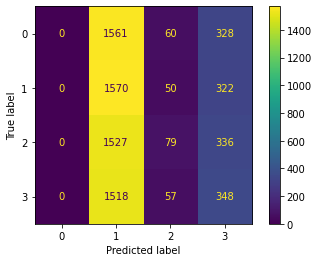

In [33]:
inc_pre = res.predict_generator(test_it)
#winsound.Beep(1000,2000) ###

inc_pre = [np.argmax(i) for i in inc_pre]
print("Classification Report : ", classification_report(test_it.classes, inc_pre))
print("Accuracy : ", accuracy_score(test_it.classes, inc_pre))
ConfusionMatrixDisplay(confusion_matrix(test_it.classes, inc_pre)).plot()